**Import packages**

In [ ]:
!pip install pytictoc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [ ]:
(X_train, y_train), (X_test,y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**Normalize the input data**

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

**Set directory**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B

Mounted at /content/gdrive
/content/gdrive/MyDrive/ECE 696B/Project - ECE696B


**Load the base models for Method 0 of Randomized Smoothing**

In [ ]:
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST.h5')
MLP_MNIST = load_model('MLP_MNIST.h5')
CNN_MNIST = load_model('CNN_MNIST.h5')

# Remember to rename the files

**Load the GNA trained models for Method 1 of Randomized Smoothing**

In [ ]:
# from keras.models import load_model
# Linear_MNIST = load_model('Linear_MNIST_GNA_trained.h5')
# MLP_MNIST = load_model('MLP_MNIST_GNA_trained.h5')
# CNN_MNIST = load_model('CNN_MNIST_GNA_trained.h5')

# # Remember to rename the files

# Randomized Smoothing

**Function for performning randomized smoothing**

In [ ]:
from scipy.stats import norm
def randomized_smoothing(model, x, y, sigma, num_examples):
  y_pred_stack = np.empty((0,10))
  for i in range(num_examples):  
    noise = np.random.normal(size=x.shape, loc=0.0, scale=sigma)
    x_neighbor = x + noise
    x_neighbor = np.clip(x_neighbor, 0, 1)
    y_pred = np.squeeze(model(x_neighbor[np.newaxis, ...]).numpy())
    y_pred_stack = np.vstack((y_pred_stack, y_pred))
  combined_y_pred = np.sum(y_pred_stack, axis = 0)
  combined_y_pred_normalized = combined_y_pred / np.sum(combined_y_pred)
  a = int(np.argsort(-combined_y_pred_normalized)[0])
  b = int(np.argsort(-combined_y_pred_normalized)[1])
  P_a = combined_y_pred_normalized[a]
  P_b = combined_y_pred_normalized[b]
  r  = (norm.ppf(P_a) - norm.ppf(P_b))*(sigma/2)
  if a == y: prediction_result = 1
  else: prediction_result = 0

  return prediction_result, r

# Robust accuracy calculations for different models

**Global parameters**

In [ ]:
num_examples = 100
sigma_points = np.array([0.3])

**For Linear model**

In [ ]:
model = Linear_MNIST;
for sigma in sigma_points:
  prediction_result_collection = []
  r_values = []
  for i in range(1000):
    x = X_test[i]
    y = y_test[i]
    prediction_result, r = randomized_smoothing(model, x, y, sigma, num_examples)
    prediction_result_collection.append(prediction_result)
    r_values.append(r)
  prediction_result_collection = np.array(prediction_result_collection)
  r_values = np.array(r_values)

  np_array_filename = 'MNIST_RandomizedSmooting_Linear_sigma'+ str(sigma) + '.npz'
  np.savez(np_array_filename, prediction_result_collection=prediction_result_collection, r_values=r_values)

**For MLP model**

In [ ]:
model = MLP_MNIST;
for sigma in sigma_points:
  prediction_result_collection = []
  r_values = []
  for i in range(1000):
    x = X_test[i]
    y = y_test[i]
    prediction_result, r = randomized_smoothing(model, x, y, sigma, num_examples)
    prediction_result_collection.append(prediction_result)
    r_values.append(r)
  prediction_result_collection = np.array(prediction_result_collection)
  r_values = np.array(r_values)

  np_array_filename = 'MNIST_RandomizedSmooting_MLP_sigma'+ str(sigma) + '.npz'
  np.savez(np_array_filename, prediction_result_collection=prediction_result_collection, r_values=r_values)

**For CNN model**

In [ ]:
model = CNN_MNIST;
for sigma in sigma_points:
  prediction_result_collection = []
  r_values = []
  for i in range(1000):
    x = X_test[i]
    y = y_test[i]
    prediction_result, r = randomized_smoothing(model, x, y, sigma, num_examples)
    prediction_result_collection.append(prediction_result)
    r_values.append(r)
  prediction_result_collection = np.array(prediction_result_collection)
  r_values = np.array(r_values)

  np_array_filename = 'MNIST_RandomizedSmooting_CNN_sigma'+ str(sigma) + '.npz'
  np.savez(np_array_filename, prediction_result_collection=prediction_result_collection, r_values=r_values)

# Plot robust accuracy for different models

In [ ]:
def get_robust_accuracy_values(prediction_result_collection, r_values, r_points):
  robust_accuracy = []
  for r in r_points:
    indices = np.where(r_values >= r)
    filtered_items = prediction_result_collection[indices]
    correct_items = np.sum(filtered_items)
    robust_accuracy.append(correct_items/len(r_values))
  
  return robust_accuracy 

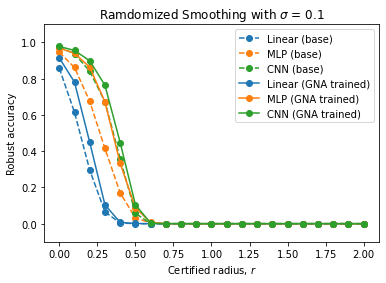

In [ ]:
sigma = 0.1
r_points = np.arange(0.0,2.1,0.1)
np_array_filename = 'MNIST_RandomizedSmooting_Linear_sigma'+ str(sigma) + '.npz'
data = np.load(np_array_filename)
prediction_result_collection = data['prediction_result_collection']
r_values = data['r_values']
robust_accuracy = get_robust_accuracy_values(prediction_result_collection, r_values, r_points)
plt.plot(r_points,robust_accuracy,'o--')

np_array_filename = 'MNIST_RandomizedSmooting_MLP_sigma'+ str(sigma) + '.npz'
data = np.load(np_array_filename)
prediction_result_collection = data['prediction_result_collection']
r_values = data['r_values']
robust_accuracy = get_robust_accuracy_values(prediction_result_collection, r_values, r_points)
plt.plot(r_points,robust_accuracy,'o--')

np_array_filename = 'MNIST_RandomizedSmooting_CNN_sigma'+ str(sigma) + '.npz'
data = np.load(np_array_filename)
prediction_result_collection = data['prediction_result_collection']
r_values = data['r_values']
robust_accuracy = get_robust_accuracy_values(prediction_result_collection, r_values, r_points)
plt.plot(r_points,robust_accuracy,'o--')

np_array_filename = 'GNA trained MNIST_RandomizedSmooting_Linear_sigma'+ str(sigma) + '.npz'
data = np.load(np_array_filename)
prediction_result_collection = data['prediction_result_collection']
r_values = data['r_values']
robust_accuracy = get_robust_accuracy_values(prediction_result_collection, r_values, r_points)
plt.plot(r_points,robust_accuracy,'o-', color = 'C0')

np_array_filename = 'GNA trained MNIST_RandomizedSmooting_MLP_sigma'+ str(sigma) + '.npz'
data = np.load(np_array_filename)
prediction_result_collection = data['prediction_result_collection']
r_values = data['r_values']
robust_accuracy = get_robust_accuracy_values(prediction_result_collection, r_values, r_points)
plt.plot(r_points,robust_accuracy,'o-', color = 'C1')

np_array_filename = 'GNA trained MNIST_RandomizedSmooting_CNN_sigma'+ str(sigma) + '.npz'
data = np.load(np_array_filename)
prediction_result_collection = data['prediction_result_collection']
r_values = data['r_values']
robust_accuracy = get_robust_accuracy_values(prediction_result_collection, r_values, r_points)
plt.plot(r_points,robust_accuracy,'o-', color = 'C2')

plt.xlabel('Certified radius, $r$')
plt.ylabel('Robust accuracy')
plt.ylim([-0.1,1.1])
string = 'Ramdomized Smoothing with $\sigma$ = ' + str(sigma)
plt.title(string)
plt.legend(['Linear (base)', 'MLP (base)','CNN (base)', 'Linear (GNA trained)', 'MLP (GNA trained)','CNN (GNA trained)'])
filename = 'Ramdomized Smoothing on base models & GNA trained with sigma ' + str(sigma) + '[MNIST].png'
plt.savefig(filename, dpi=600)
plt.show()